# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [201]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [202]:
# Read the Mapbox API key
load_dotenv("sample.env")
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [203]:
# Import the necessary CSVs to Pandas DataFrames
# Read the census data into a Pandas DataFrame
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

# Load neighborhoods coordinates data
csvpath = Path("Data/neighborhoods_coordinates.csv")
coord_df = pd.read_csv(csvpath, index_col='Neighborhood') 

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [204]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    # Calculate the mean number of housing units per year (hint: use groupby) 
    sfo_data_grp = sfo_data['housing_units'].groupby('year').mean().reset_index()

    # Optional Challenge: Use the min, max, and std to scale the y limits of the chart
    min_yaxis = sfo_data_grp['housing_units'].min() - sfo_data_grp['housing_units'].std()
    max_yaxis = sfo_data_grp['housing_units'].max() + sfo_data_grp['housing_units'].std()
 
    # Return plot as plot
    return px.bar(
        sfo_data_grp,
        x='year',
        y='housing_units',
        title='Housing Units in San Francisco from 2010 to 2016',
        labels=dict(year="Year", housing_units="Housing Units") 
        ).update_yaxes(range=[min_yaxis, max_yaxis])


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    # Calculate the average sale price per square foot and average gross rent
    sfo_data_sale_rent = sfo_data[['sale_price_sqr_foot', 'gross_rent']].groupby('year').mean().reset_index()

    # Return plot as pane object
    return px.line(
        sfo_data_sale_rent,
        x='year',
        y='gross_rent',
        title="Average Gross Rent by Year",
        labels=dict(year="Year", gross_rent="Gross Rent"),
        )


def average_sales_price():
    """Average Sales Price Per Year."""
    
    # Calculate the average sale price per square foot and average gross rent
    sfo_data_sale_rent = sfo_data[['sale_price_sqr_foot', 'gross_rent']].groupby('year').mean().reset_index()

    # Return line chart for average sale price per square foot
    return px.line(
        sfo_data_sale_rent,
        x='year',
        y='sale_price_sqr_foot',
        title="Average Price per SqFt by Year",
        labels=dict(year="Year", sale_price_sqr_foot="Sale Price per Square Foot")
        )


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    # Group by year and neighborhood and then create a new dataframe of the mean values
    sfo_hood = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'gross_rent', 'housing_units']].groupby(
    ['year', 'neighborhood']).mean().reset_index()

    # Return hvplot to create an interactive line chart of the average price per sq ft.
    return sfo_hood.hvplot(
        x="year",
        y="sale_price_sqr_foot",
        xlabel="Year",
        ylabel="Avg Sale Price per Square Foot",
        groupby='neighborhood'
        )

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    # Group by year and neighborhood and then create a new dataframe of the mean values
    sfo_hood = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'gross_rent', 'housing_units']].groupby(
    ['year', 'neighborhood']).mean().reset_index()

    # Getting the data from the top 10 expensive neighborhoods to own
    # Note I've selected 2016 values only as it seems most relevant
    sfo_2016 = sfo_hood[sfo_hood['year'] == 2016].sort_values('sale_price_sqr_foot', ascending=False).reset_index()

    # Drop extra index column
    sfo_2016.drop(columns='index', inplace=True)

    # Select top-10 most expensive
    sfo_2016_10 = sfo_2016.iloc[0:10]
    sfo_2016_10

    # Plotting the data from the top 10 expensive neighborhoods
    return sfo_2016_10.hvplot(
        kind='bar', title='Top 10 Most Expensive Neighborhoods in SFO in 2016', 
        x='neighborhood', 
        y="sale_price_sqr_foot", 
        xlabel="Neighborhood", 
        ylabel="Avg Sales Price per Square Foot", 
        width=700, 
        height=500, 
        rot=90
        )

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    # Group by year and neighborhood and then create a new dataframe of the mean values
    sfo_hood = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'gross_rent', 'housing_units']].groupby(
    ['year', 'neighborhood']).mean().reset_index()
    
    # Plotting the data from the top 10 expensive neighborhoods
    return sfo_hood.hvplot(
        kind='bar',
        x='year',
        y=['gross_rent', 'sale_price_sqr_foot'],
        title='Sales Prices and Rent 2010-2016 per Neighborhood',
        xlabel="Year", 
        ylabel="Gross Rent/Sale Price per Square Foot", 
        rot=90,
        width=700, 
        height=500, 
        groupby='neighborhood'
        )

def parallel_coordinates():
    """Parallel Coordinates Plot."""

    # Fetch the data from all expensive neighborhoods per year.
    sfo_hood = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'gross_rent', 'housing_units']].groupby(
    ['year', 'neighborhood']).mean().reset_index()

    # Getting the data from the top 10 expensive neighborhoods to own
    # Note I've selected 2016 values only as it seems most relevant
    sfo_2016 = sfo_hood[sfo_hood['year'] == 2016].sort_values('sale_price_sqr_foot', ascending=False).reset_index()

    # Drop extra index column
    sfo_2016.drop(columns='index', inplace=True)

    # Select top-10 most expensive
    sfo_2016_10 = sfo_2016.iloc[0:10]

    df_expensive_neighborhoods_per_year = sfo_hood[sfo_hood["neighborhood"].isin(sfo_2016_10["neighborhood"])].reset_index()
    df_expensive_neighborhoods_per_year.drop(columns='index', inplace=True)

    # calculate mean across years
    df_expensive_neighborhoods_per_year_grp = df_expensive_neighborhoods_per_year.groupby(by='neighborhood')[
        'sale_price_sqr_foot', 'gross_rent', 'housing_units'].mean().reset_index()


    # Return parallel Coordinates Plot
    return px.parallel_coordinates(
        data_frame=df_expensive_neighborhoods_per_year_grp,
        color='sale_price_sqr_foot',
        title='Parallel Coordinates Analysis of Most Expensive San Francisco Neighborhoods',
        )

def parallel_categories():
    """Parallel Categories Plot."""
    
    # Fetch the data from all expensive neighborhoods per year.
    sfo_hood = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'gross_rent', 'housing_units']].groupby(
    ['year', 'neighborhood']).mean().reset_index()

    # Getting the data from the top 10 expensive neighborhoods to own
    # Note I've selected 2016 values only as it seems most relevant
    sfo_2016 = sfo_hood[sfo_hood['year'] == 2016].sort_values('sale_price_sqr_foot', ascending=False).reset_index()

    # Drop extra index column
    sfo_2016.drop(columns='index', inplace=True)

    # Select top-10 most expensive
    sfo_2016_10 = sfo_2016.iloc[0:10]

    df_expensive_neighborhoods_per_year = sfo_hood[sfo_hood["neighborhood"].isin(sfo_2016_10["neighborhood"])].reset_index()
    df_expensive_neighborhoods_per_year.drop(columns='index', inplace=True)

    # calculate mean across years
    df_expensive_neighborhoods_per_year_grp = df_expensive_neighborhoods_per_year.groupby(by='neighborhood')[
        'sale_price_sqr_foot', 'gross_rent', 'housing_units'].mean().reset_index()

    # Return parallel Categories Plot
    return px.parallel_categories(
        data_frame=df_expensive_neighborhoods_per_year_grp,
        color='sale_price_sqr_foot',
        title='Parallel Categories Analysis of Most Expensive San Francisco Neighborhoods',
        color_continuous_scale=px.colors.sequential.Inferno,
        dimensions_max_cardinality=50,
        )

def neighborhood_map():
    """Neighborhood Map."""

    # Read the Mapbox API key
    px.set_mapbox_access_token(map_box_api)

    # Fetch the data from all expensive neighborhoods per year.
    sfo_hood = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'gross_rent', 'housing_units']].groupby(
    ['year', 'neighborhood']).mean().reset_index()

    # Calculate the mean values for each neighborhood
    # I'm using the latest 2016 values instead of mean values as I believe this to be more useful
    sfo_2016 = sfo_hood[sfo_hood['year'] == 2016].sort_values('sale_price_sqr_foot', ascending=False).set_index('neighborhood')

    # # Join the average values with the neighborhood locations
    join_df = pd.concat([coord_df, sfo_2016], join='inner', axis=1).dropna()

    # Return scatter mapbox to analyze neighborhood info
    return px.scatter_mapbox(
            join_df,
            lat='Lat',
            lon='Lon',
            size='sale_price_sqr_foot',
            color='gross_rent',
            zoom=10,
            width=750,
            height=500,
            title = 'Average Sale Price Per Square Foot and Gross Rent in San Francisco'
            )


def sunburst():
    """Sunburst Plot."""
    
    # Fetch the data from all expensive neighborhoods per year.
    sfo_hood = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'gross_rent', 'housing_units']].groupby(
    ['year', 'neighborhood']).mean().reset_index()

    # Getting the data from the top 10 expensive neighborhoods to own
    # Note I've selected 2016 values only as it seems most relevant
    sfo_2016 = sfo_hood[sfo_hood['year'] == 2016].sort_values('sale_price_sqr_foot', ascending=False).reset_index()

    # Drop extra index column
    sfo_2016.drop(columns='index', inplace=True)

    # Select top-10 most expensive
    sfo_2016_10 = sfo_2016.iloc[0:10]
    
    df_expensive_neighborhoods_per_year = sfo_hood[sfo_hood["neighborhood"].isin(sfo_2016_10["neighborhood"])].reset_index()
    df_expensive_neighborhoods_per_year.drop(columns='index', inplace=True)

    # Return sunburst Plot
    return px.sunburst(
        df_expensive_neighborhoods_per_year,
        path=['year', 'neighborhood'],
        values='sale_price_sqr_foot',
        color='gross_rent',
        title='Costs Analysis of Most Expensive neighborhoods in San Francisco per Year',
        width=800,
        height=600,
        )


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [205]:
# Create a Title for the Dashboard

# Create a tab layout for the dashboard

column_sfo = pn.Column(housing_units_per_year(), average_gross_rent(), average_sales_price())

column_neighborhood = pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods(), 
                          most_expensive_neighborhoods_rent_sales())

column_parallel = pn.Column(parallel_coordinates(), parallel_categories())

tabs = pn.Tabs(
    ("San Francisco", column_sfo),
    ("Neighborhood", column_neighborhood),
    ("Correlations", column_parallel),
    ("Map", neighborhood_map()),
    ("Sunburst", sunburst())
    )

column_dashboard = pn.Column('# Welcome to the San Francisco real estate dashboard', tabs)
column_dashboard

# Create the dashboard
# YOUR CODE HERE!

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Plotly(Figure)
            [1] Plotly(Figure)
            [2] Plotly(Figure)
        [1] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
            [2] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
        [2] Column
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [3] Plotly(Figure, name='Map')
        [4] Plotly(Figure, name='Sunburst')

## Serve the Panel Dashboard

In [206]:
# Serve the# dashboard
column_dashboard.servable()

Column
    [0] Markdown(str)
    [1] Tabs(active=1)
        [0] Column
            [0] Plotly(Figure, relayout_data={'autosize': True}, viewport={'xaxis.range': [2009.5, ...})
            [1] Plotly(Figure, relayout_data={'autosize': True}, viewport={'xaxis.range': [2010, ...})
            [2] Plotly(Figure, relayout_data={'autosize': True}, viewport={'xaxis.range': [2010, ...})
        [1] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
            [2] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
        [2] Column
            [0] Plotly(Figure, relayout_data={'autosize': True})
            [1] Plotly(Figure, relayout_data={'autosize': True})
        [3] Plotly(Figure, name='Map')
        [4] Plotly(Figure, name='Sunburst')

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

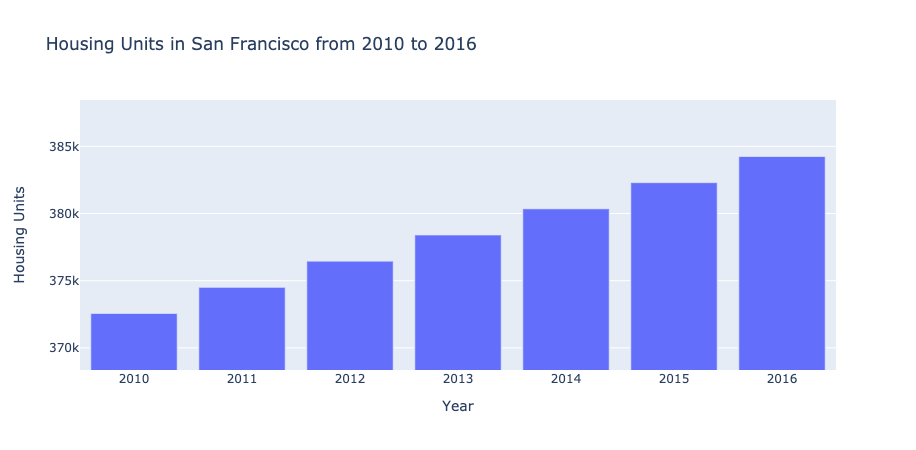

In [83]:
housing_units_per_year()

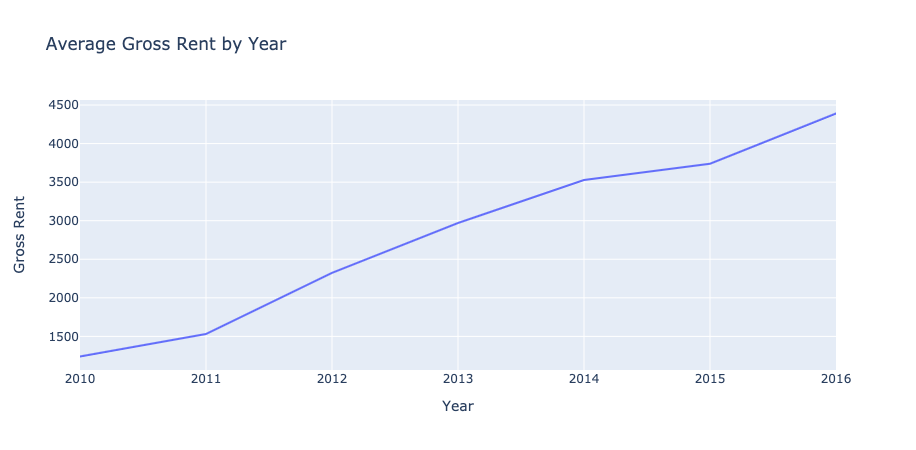

In [85]:
average_gross_rent()

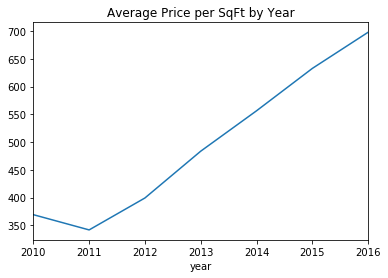

In [84]:
average_sales_price()

In [96]:
average_price_by_neighborhood()

Row
    [0] HoloViews(DynamicMap)
    [1] Column
        [0] WidgetBox
            [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
        [1] VSpacer()

In [207]:
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [208]:
most_expensive_neighborhoods_rent_sales()

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

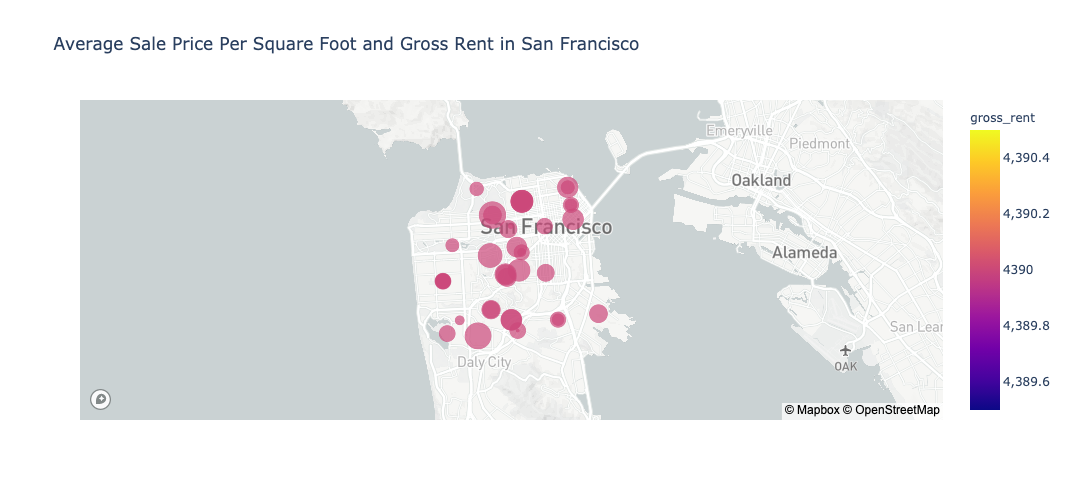

In [209]:
neighborhood_map()

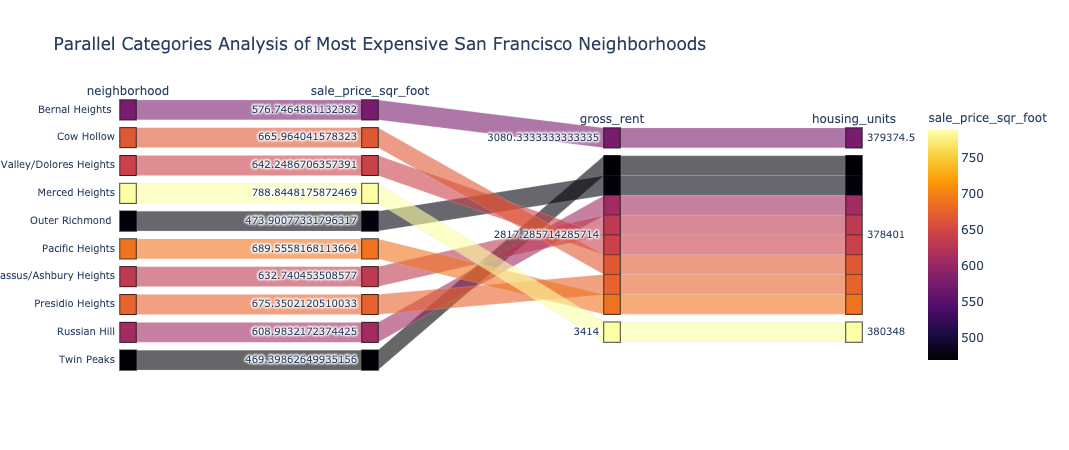

In [210]:
parallel_categories()

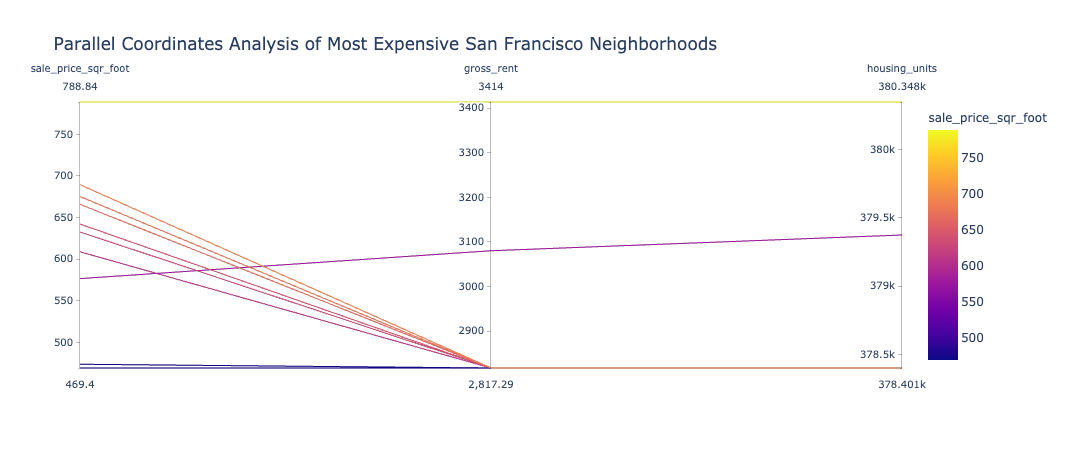

In [211]:
parallel_coordinates()

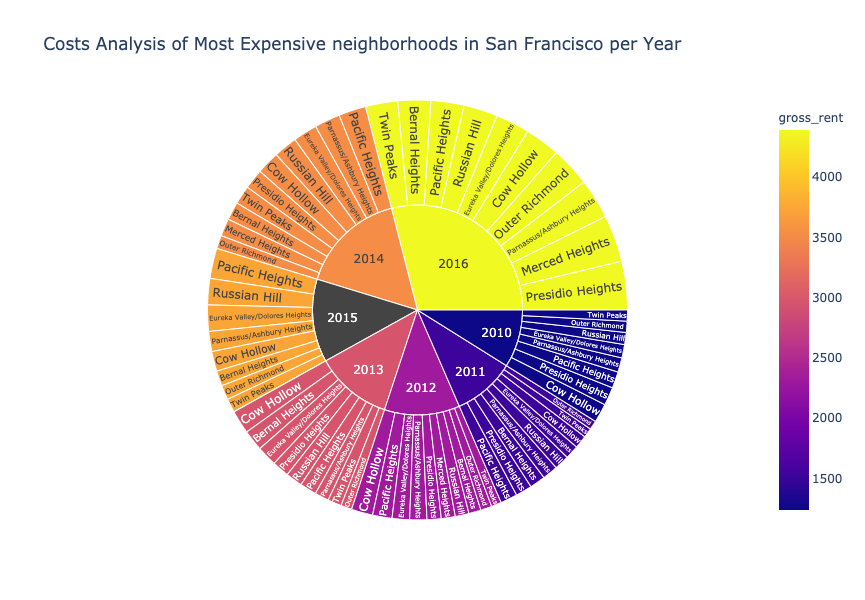

In [118]:
sunburst()